# Clustering Algorithm

In this notebook we will take the cleaned botany data *data/labeled_clean_df.csv* and use an sklearn pipeline with parameter tuning to determine the best clustering algorithm parameters.

In [38]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [39]:
import numpy as np
import pandas as pd
from cluster_pipeline import create_pipeline, custom_cv_search
from plotting import plot_geographical_positions

In [40]:
# Import the labeled, clean dataframe created in manual_cluster_labeling.ipynb

full_df = pd.read_csv("../data/labeled_clean_df.csv", index_col=0)

In [5]:
full_df.columns

Index(['index', 'collectingeventid', 'startdate', 'enddate', 'remarks',
       'localityid', 'collectionobjectid', 'text1', 'minelevation',
       'maxelevation', 'elevationaccuracy', 'latitude1', 'longitude1',
       'localityname', 'namedplace', 'geographyid', 'centroidlat',
       'centroidlon', 'commonname', 'fullname', 'name', 'spatial_flag',
       'cluster'],
      dtype='object')

## 1. Simple Clustering: Spatiotemporal

First, we will build a pipeline that will transform and perform dbscan clustering on our data. We will then compare the results of this clustering against the 11 manually labeled clusters.

In [6]:
# Subset the full_df to only the columns we care about. For readability
df = full_df.reset_index(drop=True)[["collectingeventid", "startdate", "remarks", "latitude1", "longitude1", "localityname", "cluster"]]

df

,collectingeventid,startdate,remarks,latitude1,longitude1,localityname,cluster
0,536221.0,1808-04-20,NaN,26.495565,88.114457,Bhatgong [=Bhatgaon?],NaN
1,441847.0,1808-04-20,NaN,26.495565,88.114457,"habitat in montosis Camrupa [Kamrup?], Bhatgon...",NaN
2,536220.0,1809-04-01,NaN,26.520000,88.730000,Jolpigory [=Jalpaiguri],NaN
3,550870.0,1809-04-01,NaN,26.520000,88.730000,Jolpigory [=Jalpaiguri],NaN
4,487639.0,1809-04-01,NaN,26.520000,88.730000,"habitat in montosis Camrupa [Kamrup?], Jolpigo...",NaN
...,...,...,...,...,...,...,...
239348,996140.0,2024-09-30,"Open, sunny. At top of bank of creek and road ...",47.053971,-122.719350,"unincorporated county, west side of Hartman Rd...",NaN
239349,996141.0,2024-10-09,"Open, sunny, lightly vegetated cobble/gravel b...",46.857071,-122.306897,"unincorporated county, Mashel River, 0.2 miles...",NaN
239350,996142.0,2024-10-14,"Very steep, north- to northwest-facing, open, ...",47.031033,-122.912741,"Olympia, southeast side of Lakeridge Dr SW, 70...",NaN
239351,996144.0,2024-10-17,"Flat, ruderal, weedy area and adjacent man-mad...",46.973870,-122.882312,"unincorporated county, northwestern edge of a ...",NaN


### a. CV Search Parameter Tuning

In [7]:
# Creating this pipeline here so its parameters can be adjusted and tuned in custom_cv_search below
pipeline = create_pipeline(e_dist=0.01, e_days=30)

# Creating a parameter grid to run across the cv search. NOTE: This could be extended, made more granular
param_grid = {
    "spatial_dbscan__e_dist": [.1, 1, 5, 10, 15, 20],
    "temporal_dbscan__e_days": [3, 5, 7, 9, 10]
}

best_params, best_score, scores = custom_cv_search(df, pipeline, param_grid)

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("All Scores:", scores)

Best Parameters: {'spatial_dbscan__e_dist': 5, 'temporal_dbscan__e_days': 7}
Best Score: 0.294776395337642
All Scores: [0.525298089912039, 0.525298089912039, 0.525298089912039, 0.525298089912039, 0.525298089912039, 0.47347194435947826, 0.47347194435947826, 0.47347194435947826, 0.47347194435947826, 0.47347194435947826, 0.3033478239090705, 0.3033478239090705, 0.294776395337642, 2.5852525858138327, 2.5852525858138327, 29.55104474771983, 35.71354474771982, 70.80679047997499, 70.80679047997499, 91.02551689506933, 29.588466131367625, 35.86346613136763, 80.67331114484472, 93.72979137844759, 93.72979137844759, 29.588618686668923, 35.86361868666893, 80.67346370014602, 93.72994393374888, 93.72994393374888]


In [8]:
best_params

{'spatial_dbscan__e_dist': 5, 'temporal_dbscan__e_days': 7}

### b. Fit Pipeline with best params

In [9]:
pipeline = create_pipeline(e_dist=best_params["spatial_dbscan__e_dist"], e_days=best_params["temporal_dbscan__e_days"])

processed_df = pipeline.transform(df)

In [10]:
pipeline

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('spatial_dbscan', SpatialDBSCAN(e_dist=5)),
                ('temporal_dbscan', TemporalDBSCAN(e_days=7)),
                ('combine_clusters', CombineClusters())])

In [11]:
processed_df.cluster

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
239348   NaN
239349   NaN
239350   NaN
239351   NaN
239352   NaN
Name: cluster, Length: 239147, dtype: float64

In [12]:
for i in np.arange(0, 11):
    df1 = processed_df[processed_df.cluster == i]
    stc_id = df1.spatiotemporal_cluster_id.sample(1).values[0]
    print("clust", i, "- manual size: ", len(df1), ", algorithm size: ", len(processed_df[processed_df.spatiotemporal_cluster_id == stc_id]))

clust 0 - manual size:  265 , algorithm size:  267
clust 1 - manual size:  8 , algorithm size:  8
clust 2 - manual size:  1 , algorithm size:  1
clust 3 - manual size:  2622 , algorithm size:  2291
clust 4 - manual size:  3846 , algorithm size:  1486
clust 5 - manual size:  59 , algorithm size:  59
clust 6 - manual size:  70 , algorithm size:  47
clust 7 - manual size:  1 , algorithm size:  1
clust 8 - manual size:  7 , algorithm size:  7
clust 9 - manual size:  21 , algorithm size:  8
clust 10 - manual size:  1072 , algorithm size:  1034


In [13]:
processed_df.to_csv("../data/processed_df.csv")

In [35]:
full_processed_df = full_df.merge(right=processed_df[["collectingeventid", "cluster", "spatiotemporal_cluster_id"]])

In [37]:
full_df

,index,collectingeventid,startdate,enddate,remarks,localityid,collectionobjectid,text1,minelevation,maxelevation,...,localityname,namedplace,geographyid,centroidlat,centroidlon,commonname,fullname,name,spatial_flag,cluster
111826,420426.0,536221.0,1808-04-20,NaN,NaN,536942.0,694989,NaN,NaN,NaN,...,Bhatgong [=Bhatgaon?],NaN,33649.0,NaN,NaN,NaN,"Kishanganj, State of Bihar, India",Kishanganj,1.0,NaN
97080,343454.0,441847.0,1808-04-20,NaN,NaN,442466.0,598227,NaN,NaN,NaN,...,"habitat in montosis Camrupa [Kamrup?], Bhatgon...",NaN,33649.0,NaN,NaN,NaN,"Kishanganj, State of Bihar, India",Kishanganj,1.0,NaN
111825,420425.0,536220.0,1809-04-01,NaN,NaN,536941.0,694988,NaN,NaN,NaN,...,Jolpigory [=Jalpaiguri],NaN,33612.0,NaN,NaN,NaN,"Jalpaiguri, State of West Bengal, India",Jalpaiguri,1.0,NaN
114498,431462.0,550870.0,1809-04-01,NaN,NaN,536941.0,710227,NaN,NaN,NaN,...,Jolpigory [=Jalpaiguri],NaN,33612.0,NaN,NaN,NaN,"Jalpaiguri, State of West Bengal, India",Jalpaiguri,1.0,NaN
104169,379936.0,487639.0,1809-04-01,NaN,NaN,488822.0,645110,NaN,NaN,NaN,...,"habitat in montosis Camrupa [Kamrup?], Jolpigo...",NaN,33612.0,NaN,NaN,NaN,"Jalpaiguri, State of West Bengal, India",Jalpaiguri,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233724,813123.0,996140.0,2024-09-30,NaN,"Open, sunny. At top of bank of creek and road ...",931454.0,1161331,"Twining vine. A single patch, 20 feet x 5 feet...",15.0,NaN,...,"unincorporated county, west side of Hartman Rd...",NaN,25774.0,46.92,-100.0,NaN,"Thurston County, Washington, United States",Thurston County,1.0,NaN
233725,813124.0,996141.0,2024-10-09,NaN,"Open, sunny, lightly vegetated cobble/gravel b...",931455.0,1161332,"Uncommon. Past peak bloom, plants mostly in fr...",620.0,NaN,...,"unincorporated county, Mashel River, 0.2 miles...",NaN,20673.0,47.03,-100.0,NaN,"Pierce County, Washington, United States",Pierce County,1.0,NaN
233726,813125.0,996142.0,2024-10-14,NaN,"Very steep, north- to northwest-facing, open, ...",931456.0,1161333,Small colony of multi-stemmed shrubs of varyin...,100.0,NaN,...,"Olympia, southeast side of Lakeridge Dr SW, 70...",NaN,25774.0,46.92,-100.0,NaN,"Thurston County, Washington, United States",Thurston County,1.0,NaN
233728,813127.0,996144.0,2024-10-17,NaN,"Flat, ruderal, weedy area and adjacent man-mad...",931458.0,1161335,Numerous ramets or individuals. Multi-stemmed ...,205.0,NaN,...,"unincorporated county, northwestern edge of a ...",NaN,25774.0,46.92,-100.0,NaN,"Thurston County, Washington, United States",Thurston County,1.0,NaN


In [36]:
full_processed_df

,index,collectingeventid,startdate,enddate,remarks,localityid,collectionobjectid,text1,minelevation,maxelevation,...,namedplace,geographyid,centroidlat,centroidlon,commonname,fullname,name,spatial_flag,cluster,spatiotemporal_cluster_id
0,420426.0,536221.0,1808-04-20,NaN,NaN,536942.0,694989,NaN,NaN,NaN,...,NaN,33649.0,NaN,NaN,NaN,"Kishanganj, State of Bihar, India",Kishanganj,1.0,NaN,0
1,343454.0,441847.0,1808-04-20,NaN,NaN,442466.0,598227,NaN,NaN,NaN,...,NaN,33649.0,NaN,NaN,NaN,"Kishanganj, State of Bihar, India",Kishanganj,1.0,NaN,0
2,420425.0,536220.0,1809-04-01,NaN,NaN,536941.0,694988,NaN,NaN,NaN,...,NaN,33612.0,NaN,NaN,NaN,"Jalpaiguri, State of West Bengal, India",Jalpaiguri,1.0,NaN,1
3,431462.0,550870.0,1809-04-01,NaN,NaN,536941.0,710227,NaN,NaN,NaN,...,NaN,33612.0,NaN,NaN,NaN,"Jalpaiguri, State of West Bengal, India",Jalpaiguri,1.0,NaN,1
4,379936.0,487639.0,1809-04-01,NaN,NaN,488822.0,645110,NaN,NaN,NaN,...,NaN,33612.0,NaN,NaN,NaN,"Jalpaiguri, State of West Bengal, India",Jalpaiguri,1.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239142,813123.0,996140.0,2024-09-30,NaN,"Open, sunny. At top of bank of creek and road ...",931454.0,1161331,"Twining vine. A single patch, 20 feet x 5 feet...",15.0,NaN,...,NaN,25774.0,46.92,-100.0,NaN,"Thurston County, Washington, United States",Thurston County,1.0,NaN,35352
239143,813124.0,996141.0,2024-10-09,NaN,"Open, sunny, lightly vegetated cobble/gravel b...",931455.0,1161332,"Uncommon. Past peak bloom, plants mostly in fr...",620.0,NaN,...,NaN,20673.0,47.03,-100.0,NaN,"Pierce County, Washington, United States",Pierce County,1.0,NaN,35353
239144,813125.0,996142.0,2024-10-14,NaN,"Very steep, north- to northwest-facing, open, ...",931456.0,1161333,Small colony of multi-stemmed shrubs of varyin...,100.0,NaN,...,NaN,25774.0,46.92,-100.0,NaN,"Thurston County, Washington, United States",Thurston County,1.0,NaN,35354
239145,813127.0,996144.0,2024-10-17,NaN,"Flat, ruderal, weedy area and adjacent man-mad...",931458.0,1161335,Numerous ramets or individuals. Multi-stemmed ...,205.0,NaN,...,NaN,25774.0,46.92,-100.0,NaN,"Thurston County, Washington, United States",Thurston County,1.0,NaN,35355


In [32]:
full_processed_df.to_csv("../data/full_processed_df.csv")

### c. Visual Inspection

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


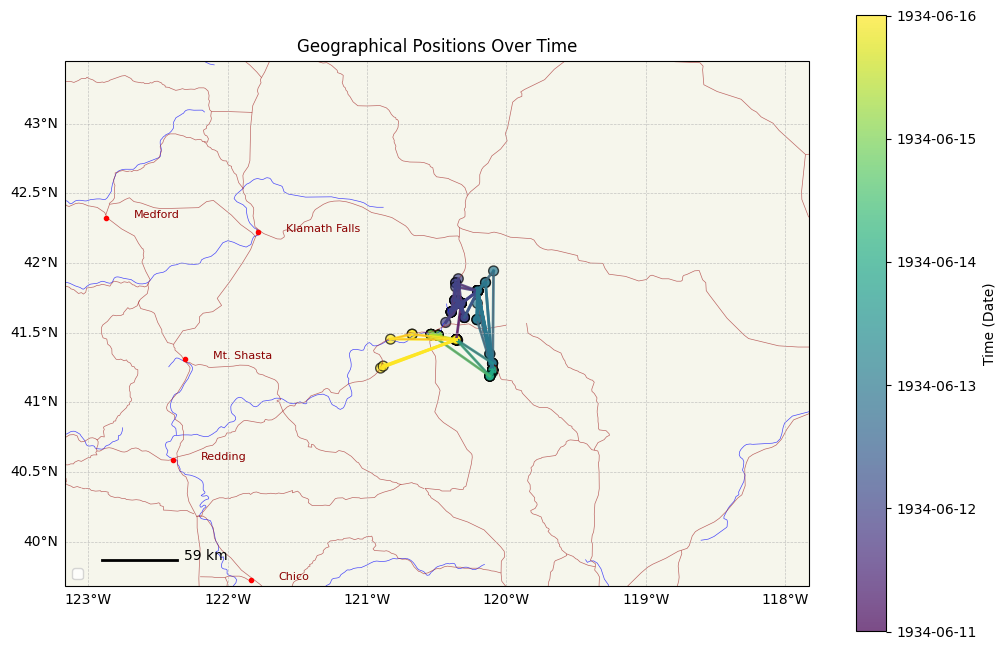

In [14]:
i = 0

stc_id = processed_df[processed_df.cluster == i].iloc[0].spatiotemporal_cluster_id

plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == stc_id], lat_col="latitude1", lon_col="longitude1", datetime_col="startdate",\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, )

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


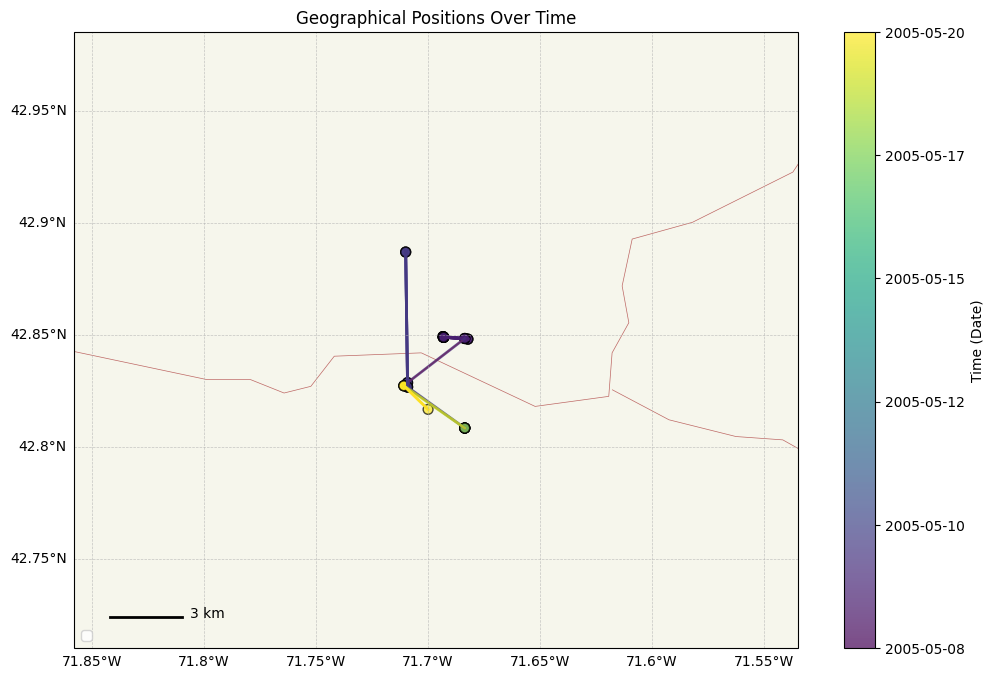

In [15]:
i = 6

stc_id = processed_df[processed_df.cluster == i].iloc[0].spatiotemporal_cluster_id

plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == stc_id], lat_col="latitude1", lon_col="longitude1", datetime_col="startdate",\
                            zoom=0.8, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, )

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


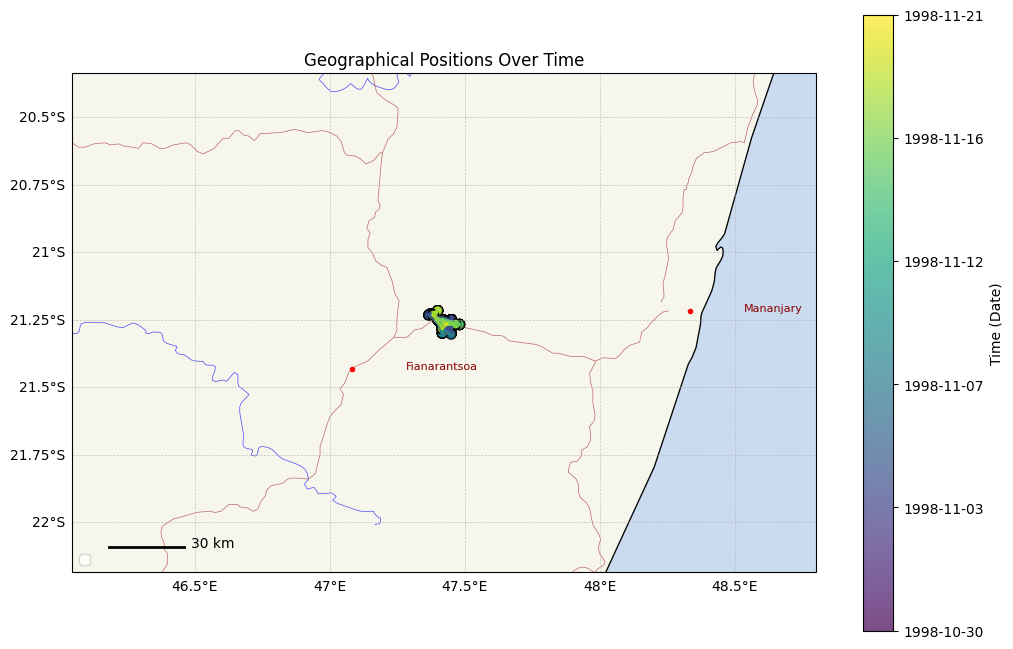

In [16]:
i = 10

stc_id = processed_df[processed_df.cluster == i].iloc[0].spatiotemporal_cluster_id

plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == stc_id], lat_col="latitude1", lon_col="longitude1", datetime_col="startdate",\
                            zoom=0.1, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, )

biggest_clusters = processed_df.groupby('spatiotemporal_cluster_id').size().sort_values(ascending=False).head(20)
biggest_clusters

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


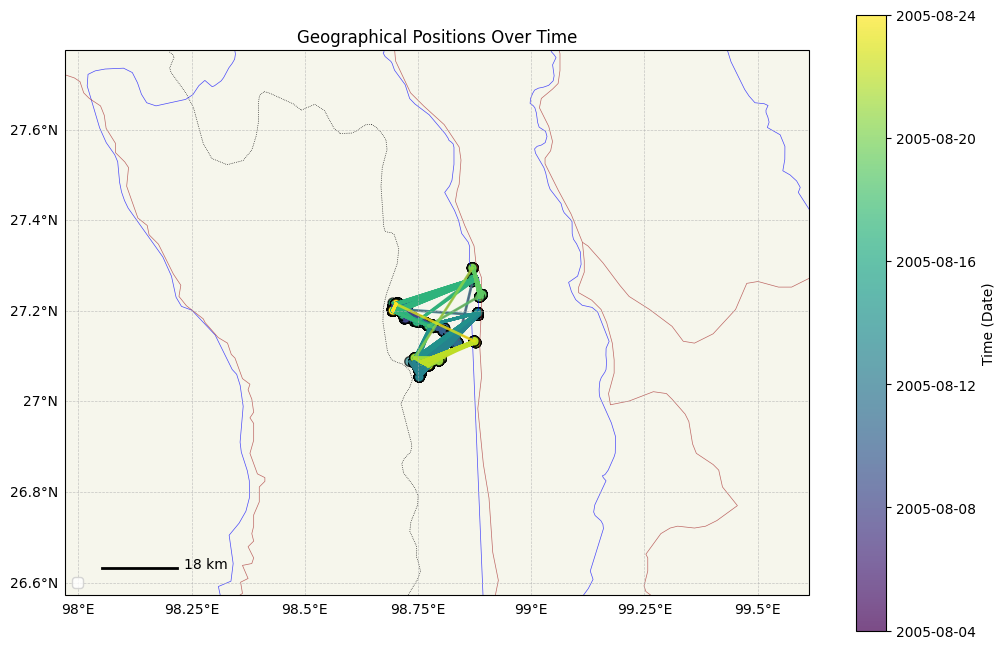

In [18]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[0]], lat_col="latitude1", lon_col="longitude1", datetime_col="startdate",\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)


/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


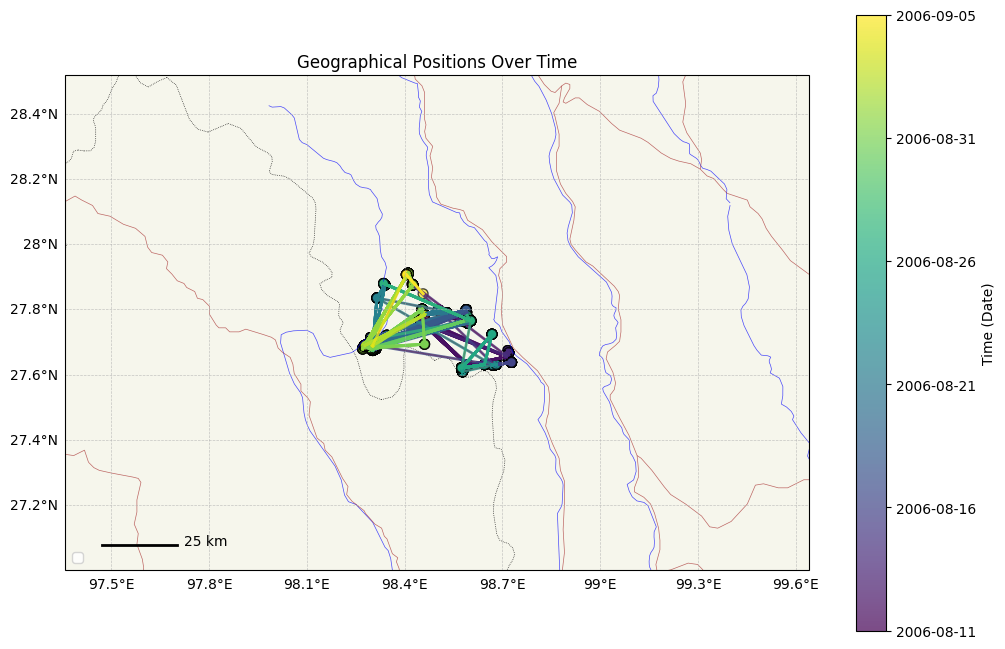

In [19]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[1]], lat_col="latitude1", lon_col="longitude1", datetime_col="startdate",\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)


/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


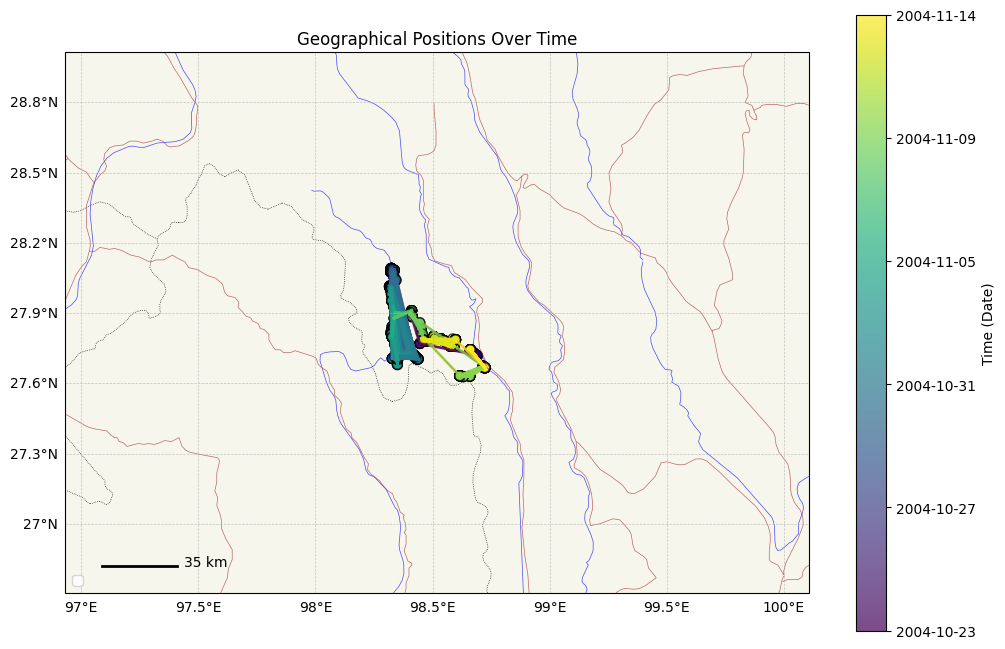

In [20]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[2]], lat_col="latitude1", lon_col="longitude1", datetime_col="startdate",\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)


/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


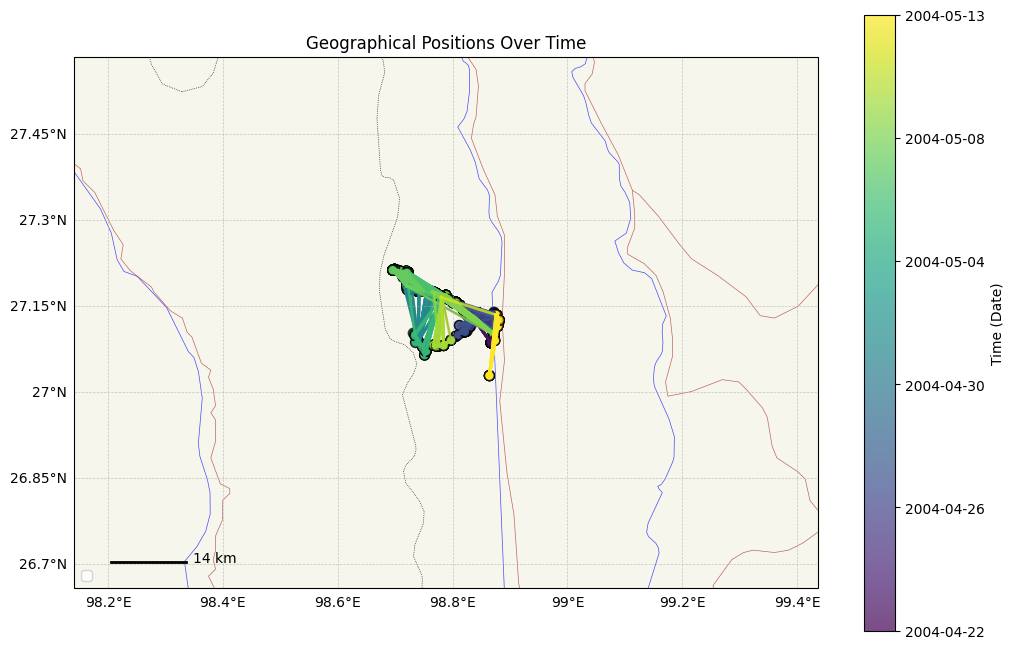

In [21]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[3]], lat_col="latitude1", lon_col="longitude1", datetime_col="startdate",\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


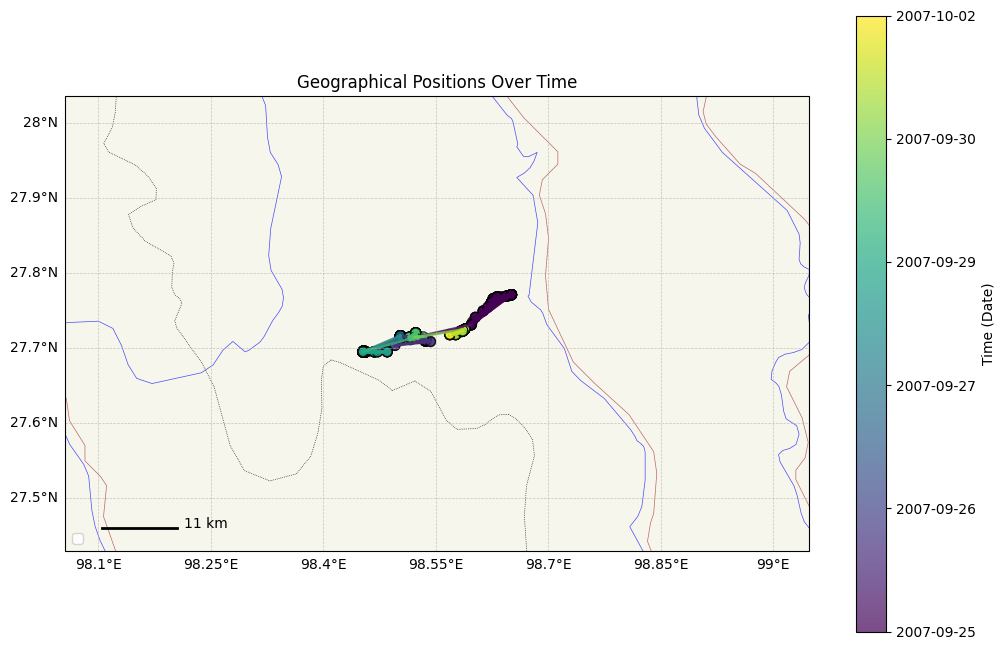

In [22]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[19]], lat_col="latitude1", lon_col="longitude1", datetime_col="startdate",\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


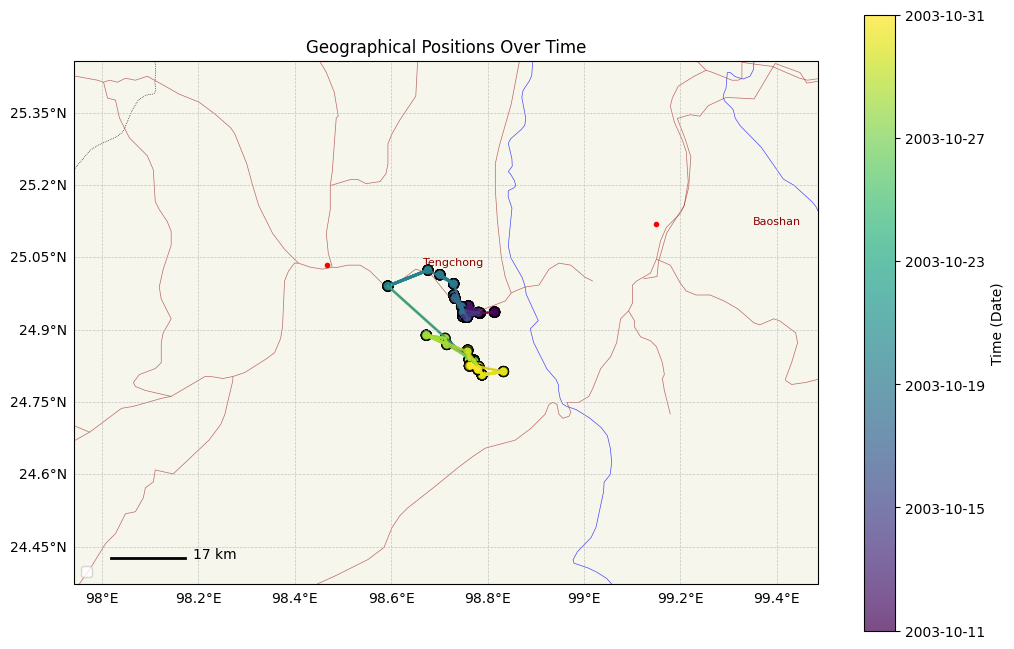

In [23]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[18]], lat_col="latitude1", lon_col="longitude1", datetime_col="startdate",\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)

# 2. Cluster Summary Statistics

In [24]:
print("Number of records: ", len(processed_df))
print("Number of clusters: ", len(processed_df.spatiotemporal_cluster_id.unique()))
print("Average cluster length: ", )

Number of records:  239147
Number of clusters:  35356
Average cluster length: 


In [25]:

# Function to calculate maximum time difference
def max_time_diff(group):
    return (group["startdate"].max() - group["startdate"].min()).days

# Function to calculate maximum distance
def max_lat(group):
    return (group["latitude1"].max() - group["latitude1"].min())

# Function to calculate maximum distance
def max_lon(group):
    return (group["longitude1"].max() - group["longitude1"].min())


# Function to calculate max differences within consecutive days in a cluster
def max_consecutive_differences(group):
    group = group.sort_values("startdate").reset_index(drop=True)
    group["time_diff"] = group["startdate"].diff().dt.days
    group["lat_diff"] = group["latitude1"].diff().abs()
    group["lon_diff"] = group["longitude1"].diff().abs()

    return pd.Series({
        "max_time_diff_consecutive": np.round(group["time_diff"].max(), 3),
        "max_lat_diff_consecutive": np.round(group["lat_diff"].max(), 3),
        "max_lon_diff_consecutive": np.round(group["lon_diff"].max(), 3),
    })

# Group by 'cluster' and compute summary statistics
summary_stats = processed_df.groupby("spatiotemporal_cluster_id").agg(
    startdate_min=("startdate", "min"),
    startdate_max=("startdate", "max"),
    latitude_mean=("latitude1", "mean"),
    latitude_std=("latitude1", "std"),
    longitude_mean=("longitude1", "mean"),
    longitude_std=("longitude1", "std"),
    count=("spatiotemporal_cluster_id", "size")
).reset_index()


# Add max time difference and max distance to summary stats
summary_stats["max_time_diff"] = processed_df.groupby("spatiotemporal_cluster_id").apply(max_time_diff).values
summary_stats["max_lat_diff"] = np.round(processed_df.groupby("spatiotemporal_cluster_id").apply(max_lat).values, 3)
summary_stats["max_lon_diff"] = np.round(processed_df.groupby("spatiotemporal_cluster_id").apply(max_lon).values, 3)

# Add max consecutive differences
consecutive_diffs = processed_df.groupby("spatiotemporal_cluster_id").apply(max_consecutive_differences).reset_index()
summary_stats = summary_stats.merge(consecutive_diffs, on="spatiotemporal_cluster_id")
summary_stats["day_range"] = summary_stats["startdate_max"] - summary_stats["startdate_min"]


/var/folders/qx/bpj16cl90cq20swjd4j79cdh0000gn/T/ipykernel_68859/852198534.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_stats['max_time_diff'] = processed_df.groupby('spatiotemporal_cluster_id').apply(max_time_diff).values
/var/folders/qx/bpj16cl90cq20swjd4j79cdh0000gn/T/ipykernel_68859/852198534.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_stats['max_lat_diff'] = np.round(pr

In [26]:
summary_stats

,spatiotemporal_cluster_id,startdate_min,startdate_max,latitude_mean,latitude_std,longitude_mean,longitude_std,count,max_time_diff,max_lat_diff,max_lon_diff,max_time_diff_consecutive,max_lat_diff_consecutive,max_lon_diff_consecutive,day_range
0,0,1808-04-20,1808-04-20,26.495565,0.000000,88.114457,0.000000,2,0,0.000,0.000,0.0,0.000,0.000,0 days
1,1,1809-04-01,1809-04-01,26.520000,0.000000,88.730000,0.000000,3,0,0.000,0.000,0.0,0.000,0.000,0 days
2,2,1824-08-19,1824-08-19,34.325200,NaN,-117.428100,NaN,1,0,0.000,0.000,NaN,NaN,NaN,0 days
3,3,1830-07-02,1830-07-02,27.830000,NaN,95.670000,NaN,1,0,0.000,0.000,NaN,NaN,NaN,0 days
4,4,1834-01-01,1834-01-01,22.558676,0.000000,88.291099,0.000000,9,0,0.000,0.000,0.0,0.000,0.000,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35351,35351,2024-09-26,2024-09-26,47.055429,NaN,-122.912680,NaN,1,0,0.000,0.000,NaN,NaN,NaN,0 days
35352,35352,2024-09-30,2024-09-30,47.053971,NaN,-122.719350,NaN,1,0,0.000,0.000,NaN,NaN,NaN,0 days
35353,35353,2024-10-09,2024-10-09,46.857071,NaN,-122.306897,NaN,1,0,0.000,0.000,NaN,NaN,NaN,0 days
35354,35354,2024-10-14,2024-10-14,47.031033,NaN,-122.912741,NaN,1,0,0.000,0.000,NaN,NaN,NaN,0 days


In [27]:
print("Average cluster date range: ", summary_stats.day_range.mean())
print("Median cluster date range: ", summary_stats.day_range.median())
print("Longest cluster date range: ", summary_stats.day_range.max())

Average cluster date range:  1 days 01:14:51.548817739
Median cluster date range:  0 days 00:00:00
Longest cluster date range:  187 days 00:00:00


In [28]:
print("Average cluster lat span: ", summary_stats.max_lat_diff.mean())
print("Median cluster lat span: ", summary_stats.max_lat_diff.median())
print("Longest cluster lat span: ", summary_stats.max_lat_diff.max())
print()
print("Average cluster lon span: ", summary_stats.max_lon_diff.mean())
print("Median cluster lon span: ", summary_stats.max_lon_diff.median())
print("Longest cluster lon span: ", summary_stats.max_lon_diff.max())

Average cluster lat span:  0.03525313949541803
Median cluster lat span:  0.0
Longest cluster lat span:  2.024

Average cluster lon span:  0.04044770336010862
Median cluster lon span:  0.0
Longest cluster lon span:  1.854


In [29]:
print("Average cluster size: ", summary_stats["count"].mean())
print("Median cluster size: ", summary_stats["count"].median())
print("Largest cluster size: ", summary_stats["count"].max())

Average cluster size:  6.763972168797375
Median cluster size:  2.0
Largest cluster size:  2981


In [33]:
summary_stats.to_csv("../data/cluster_summary_stats.csv")